In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

In [19]:
dataset = pd.read_csv('prison_dataset.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
attributes = dataset.columns.values[:-1]

In [20]:
def shuffle(X, y):
  np.random.seed(0)
  permutation = np.random.permutation(len(dataset))
  X = X[permutation, :]
  y = y[permutation]
  return X, y


def split_dataset(X, y, split_size = 0.8):
  size = len(X)
  x_train = X[: int(size * split_size), :]
  y_train = y[: int(size * split_size)]
  x_test = X[int(size * split_size) :, :]
  y_test = y[int(size * split_size) :]
  return x_train, x_test, y_train, y_test  

In [21]:
X, y = shuffle(X, y)
x_train, x_test, y_train, y_test = split_dataset(X, y)

In [22]:
class Node:
  def __init__(self):
    self.value = None
    self.name = None
    self.children = None
    self.depth = 1
    self.label = None

class DecisionTreeClassifier:
  def __init__(self, x, y, attributes, attributes_indexes, depth):
    self.x = x
    self.y = y
    self.attributes = attributes
    self.labels = np.unique(y)
    self.labelsCount = [np.sum(y == x) for x in self.labels]
    self.node = None
    self.attributes_indexes = attributes_indexes
    self.depth = depth

  def _calcEntropy(self, indexes):
    y = self.y[indexes]
    label_count = [np.sum(y == x) for x in self.labels]
    p1 = label_count[0] / (label_count[0] + label_count[1])
    p2 = label_count[1] / (label_count[0] + label_count[1])
    if p1 == 1 or p2 == 1:
      entropy = 0
    else:
      entropy = -p1 * np.log2(p1) - p2 * np.log2(p2)
    return entropy

  def _calcInformationGain(self, indexes, attribute):
    
    info_gain = self._calcEntropy(indexes)
    attribute_index = np.where(self.attributes == attribute)

    x_features = [self.x[x][attribute_index] for x in indexes]
    feature_vals = np.unique(x_features)
    num_of_feature_category = {val: [] for val in feature_vals}
    for val in feature_vals:
      num_of_feature_category[val] = x_features.count(val)

    value_indices = {val: [] for val in feature_vals}
    for i in range(len(indexes)):
      for value in feature_vals:
        if value == x_features[i]:
          value_indices[value].append(indexes[i])

    info_gain_feature = 0

    for val in feature_vals:
      info_gain_feature += num_of_feature_category[val] / len(indexes) * self._calcEntropy(value_indices[val])
                                                                                              

    info_gain = info_gain - info_gain_feature
    return info_gain


  def _maxInfoGainAttribute(self, indexes, attribute_indexes):
    attributes_gain = []
    for attribute_index in attribute_indexes:
      gain = self._calcInformationGain(indexes, self.attributes[attribute_index])
      attributes_gain.append(gain)
    best_attribute = attribute_indexes[attributes_gain.index(max(attributes_gain))]
    return self.attributes[best_attribute], best_attribute

  def fit(self):
    x_indexes = np.arange(len(self.x))
    attribute_indexes = [x for x in range(len(self.attributes))]
    self.node = self.ID3_Recursive(x_indexes, attribute_indexes, self.node)


  def ID3_Recursive(self, x_indexes, attributes_indexes, node):
    if not node:
      node = Node()
    labels = self.y[x_indexes]
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:
      node.label = unique_labels[0]
      return node

    if len(attributes_indexes) == 0 or node.depth == self.depth:
      frequencies = np.unique(labels, return_counts = True)
      value = frequencies[0][np.argmax(frequencies[1])]
      node.label = value
      return node
    

    best_attribute, best_attribute_index = self._maxInfoGainAttribute(x_indexes, attributes_indexes)
    node.name = best_attribute
    node.children = []

    attribute_values = np.unique(self.x[x_indexes, best_attribute_index])

    for attribute in attribute_values:
      child = Node()
      child.depth = node.depth + 1
      child.value = attribute
      child_x_indexes = [idx for idx in x_indexes if self.x[idx][best_attribute_index] == attribute]
      if len(child_x_indexes) == 0:
        frequencise = np.unique(labels, return_counts = True)
        value = frequencies[0][np.argmax(frequencies[1])]
        child.value = value

      else: 
        if attributes_indexes and best_attribute_index in attributes_indexes:
          attribute_to_remove = attributes_indexes.index(best_attribute_index)
          attributes_copy = attributes_indexes.copy()
          attributes_copy.pop(attribute_to_remove)
        child = self.ID3_Recursive(child_x_indexes, attributes_copy, child)
        node.children.append(child)

    return node


  def predict(self, X):
      y_pred = []
      for x in X:
        y_pred.append(self.predict_one_sample(x))
      return y_pred

  def predict_one_sample(self, X):
    x = X[self.attributes_indexes]
    curr_node = self.node
    while curr_node.label == None:
      attribute = curr_node.name
      attribute_index = np.where(self.attributes == attribute)
      attributes_values = []
      for child in curr_node.children:
        attributes_values.append(child.value)
      x_val = x[attribute_index]
      child_index = np.where(attributes_values == x_val)
      curr_node = curr_node.children[child_index[0][0]]
    return curr_node.label 

            

In [23]:
class RandomForestClassifier:
  def __init__(self, x, y, num_of_trees, attributes, depth = 3, attributes_size = 0.4, data_size = 0.5):
    self.x = x
    self.y = y
    self.Y_pred = {}
    self.Num_of_trees = num_of_trees
    self.DecisionTrees = {}
    self.attributes = attributes
    self.attributes_size = attributes_size
    self.data_size = data_size
    self.depth = depth


  def fit(self):
    num_of_attributes = int(len(self.attributes) * self.attributes_size)
    num_of_datas = int(len(self.x) * self.data_size)

    
    for curr_tree in range(self.Num_of_trees):
      x_indexes = np.random.permutation(len(self.x))
      attribute_indexes = np.random.permutation(len(self.attributes))
      x_indexes = x_indexes[:num_of_datas]
      attribute_indexes = attribute_indexes[:num_of_attributes]
      x_indexes = np.sort(x_indexes)
      attribute_indexes = np.sort(attribute_indexes)


      chosen_x = self.x[x_indexes, :]
      chosen_x = chosen_x[:, attribute_indexes]
      chosen_attributes = self.attributes[attribute_indexes]
      chosen_attributes = np.reshape(chosen_attributes, (len(chosen_attributes),))
      chosen_y = self.y[x_indexes]
      chosen_y = np.reshape(chosen_y, (len(chosen_y),))


      self.DecisionTrees['d' + str(curr_tree)] = DecisionTreeClassifier(chosen_x, chosen_y, chosen_attributes, attribute_indexes, self.depth)
      self.DecisionTrees['d' + str(curr_tree)].fit()
    print('Random Forest classifier has been trained successfully :).')




  def predict(self, x_test):
    
    for curr_tree in range(self.Num_of_trees):
      self.Y_pred['y_pred' + str(curr_tree)] = self.DecisionTrees['d' + str(curr_tree)].predict(x_test)

    y_pred = np.zeros((len(x_test), 1)).T

    for curr_tree in range(self.Num_of_trees):
      y_pred += self.Y_pred['y_pred' + str(curr_tree)]
    
    y_pred = np.array(y_pred)

    y_pred = y_pred / self.Num_of_trees

    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    y_pred = np.reshape(y_pred, (y_pred.shape[1], ))
    return y_pred.T





def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
      


In [29]:
rf = RandomForestClassifier(x_train, y_train, 7, attributes)
rf.fit()

Random Forest classifier has been trained successfully :).


Num of the trees = 7
Accuracy = 72.38


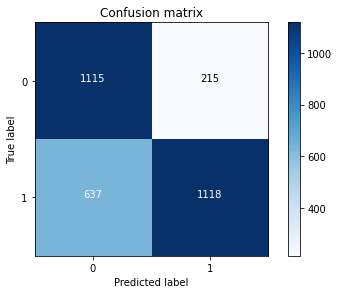

In [30]:
print('Num of the trees = {}'.format(rf.Num_of_trees))
y_pred = rf.predict(x_test)
acc = np.sum(y_pred == y_test) / len(y_pred) * 100
print('Accuracy = {:.2f}'.format(acc))
confusion_mtx = confusion_matrix(y_test, y_pred)
classes = np.unique(dataset.iloc[:, -1].values)
plot_confusion_matrix(confusion_mtx, classes)